## Setup

In [1]:
import os
import optuna
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, classification_report

from src.py_src import util
from src.py_src.models import SpecialistMXModel

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V4.parquet")
target_class = 'target_class_in_12h'
target_flux = 'target_flux_in_12h'
target_columns = [target_class, target_flux]

df_model_input = util.create_df_model_input_opt(slided_df_path, target_columns, "xl_")

Carregando 56 colunas do arquivo Parquet...


## Preparing Data

In [4]:
specialist_mx_pool = df_model_input[df_model_input[target_class] >= 4].copy()

specialist_mx_pool['target_log_flux'] = np.log10(specialist_mx_pool[target_flux] + 1e-9)
specialist_mx_pool = specialist_mx_pool.drop(columns=[target_class])

train_pct = 0.7
val_pct = (1-train_pct)/2

data = util.prepare_data(
    df_model_input=specialist_mx_pool,
    target_class_col='target_log_flux',
    lambda_function=lambda lb: lb,
    train_pct=train_pct,
    val_pct=val_pct,
    target_flux_col=target_flux
)

## Discovery Model

In [5]:
discovery_model = SpecialistMXModel(
    params={
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_jobs': -1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }
)

In [6]:
selected_features = discovery_model.discover_top_features(
    x=data['x']['train'],
    y=data['y']['train'],
    cumulative_threshold=0.95
)

--- Quick Scan (Discovery Mode) ---
Quick Scan concluído. 37 features selecionadas (de 54).


## Hyperparameter Tuning (Optuna)

In [7]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'device': 'cuda',

        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = SpecialistMXModel(params=params, features_to_keep=selected_features)

    model.fit(
        x=data['x']['train'],
        y=data['y']['train'],
        eval_set=[(data['x']['val'], data['y']['val'])],
        verbose=False
    )

    y_pred = model.predict(data['x']['val'])

    rmse = np.sqrt(mean_squared_error(data['y']['val'], y_pred))

    return -rmse

In [8]:
study = optuna.create_study(direction='maximize')
print("\nIniciando tuning...")
study.optimize(objective, n_trials=50)

print(f"\nBest Score: {study.best_value:.4f}")
best_params = study.best_params

best_params.update({
    'n_estimators': 1000, 'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 'random_state': 1502,
    'n_jobs': -1, 'early_stopping_rounds': 50
})

[I 2025-12-15 20:18:36,395] A new study created in memory with name: no-name-ec90bd6d-ed13-4c1c-8800-b3f004a7d6d1



Iniciando tuning...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:18:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-12-15 20:18:37,209] Trial 0 finished with value: -0.32504451848167626 and parameters: {'max_depth': 4, 'learning_rate': 0.05766941652723264, 'subsample': 0.8800663027074809, 'colsample_bytree': 0.7833222816786254, 'gamma': 0.5841196400755045, 'min_child_weight': 8, 'max_delta_step': 1}. Best is trial 0 with value: -0.32504451848167626.
[I 2025-12-15 20:18:38,209] Trial 1 finished with value: -0


Best Score: -0.3232


In [9]:
final_model = SpecialistMXModel(params=study.best_params, features_to_keep=selected_features)
final_model.fit(
    x=data['x']['train'],
    y=data['y']['train'],
)

,params,"{'colsample_bytree': 0.6377753043999327, 'gamma': 3.1541547521021562, 'learning_rate': 0.041553806328561906, 'max_delta_step': 6, ...}"
,features_to_keep,"['xl_std_7D', 'xl_std_24h', ...]"


## Results

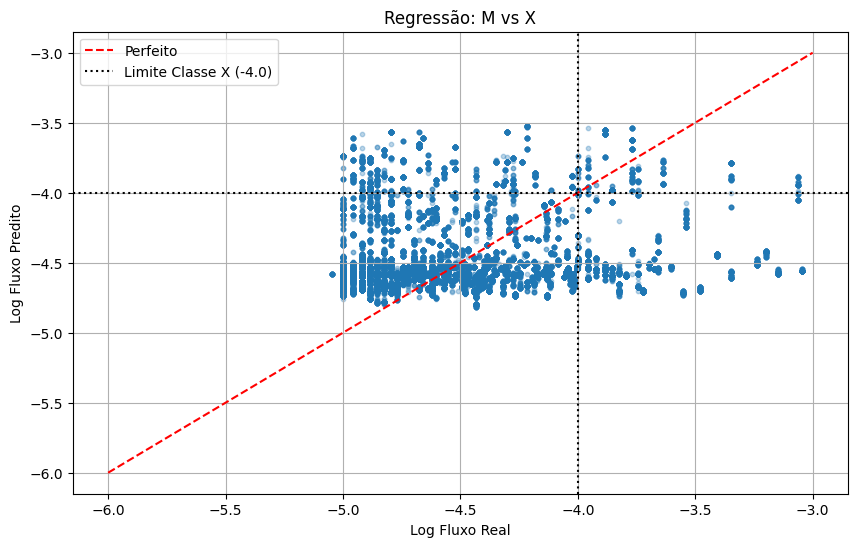

In [10]:
y_pred_log = final_model.predict(data['x']['test'])

plt.figure(figsize=(10,6))
plt.scatter(data['y']['test'], y_pred_log, alpha=0.3, s=10)
plt.plot([-6, -3], [-6, -3], 'r--', label='Perfeito') # Linha de identidade
plt.axvline(-4.0, color='k', linestyle=':', label='Limite Classe X (-4.0)')
plt.axhline(-4.0, color='k', linestyle=':')
plt.xlabel('Log Fluxo Real')
plt.ylabel('Log Fluxo Predito')
plt.title('Regressão: M vs X')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
CUTOFF_X = -4.0

y_pred_class = (y_pred_log >= CUTOFF_X).astype(int)

y_true_class = (data['y']['test'] >= CUTOFF_X).astype(int)

print("--- Relatório de Classificação (Derivado da Regressão) ---")
print(classification_report(y_true_class, y_pred_class, target_names=['M', 'X']))

--- Relatório de Classificação (Derivado da Regressão) ---
              precision    recall  f1-score   support

           M       0.89      0.92      0.90     23049
           X       0.22      0.17      0.20      3202

    accuracy                           0.83     26251
   macro avg       0.56      0.54      0.55     26251
weighted avg       0.81      0.83      0.82     26251



## Features Importance

In [12]:
features_importance = final_model.get_feature_importance()
features_importance

,feature,importance,cumulative_importance
1,xl_std_24h,0.115306,0.115306
31,xl_mean_24h,0.051925,0.167231
0,xl_std_7D,0.049991,0.217223
2,xl_max_7D,0.046412,0.263634
19,xl_mean_7D,0.044865,0.308500
5,xl_max_24h,0.042248,0.350747
3,xl_integ_7D,0.040400,0.391147
23,xl_std_12h,0.039499,0.430646
4,xl_log_mean_14D,0.037229,0.467875
7,xl_log_mean_7D,0.035765,0.503640


## Export

In [13]:
specialist_mx_dir = os.getenv('SPECIALIST_MX_MODELS_PATH')
save_path = os.path.join(specialist_mx_dir, '12h/specialist_mx_12h_v1.joblib')
final_model.save(save_path)

Modelo salvo em: C:\Users\Eduardo\BES\IC\Solar_Flares\src\notebooks\models\specialist_MX\12h/specialist_MX_12h.joblib
